In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Fri Jun 24 01:40:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   38C    P8    21W / 260W |   3450MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 28%   

# LDA

## 2010 brief paragraph

In [3]:
file_us = open("../LDA/segment/data/us_file_brief_paragraph_2010.txt", "r")
us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(us_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(520 unique tokens: ['accord', 'base', 'cell', 'channel', 'comprise']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in us_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 2), (1, 1), (2, 4), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-5.918797,371.964078
1,3,-5.894693,363.105476
2,4,-5.830861,340.651702
3,5,-5.784240,325.134709
4,6,-5.738400,310.567151
5,7,-5.747045,313.263609
6,8,-5.661780,287.660289
7,9,-5.645342,282.970199
8,10,-5.636675,280.528375
9,11,-5.620889,276.134886


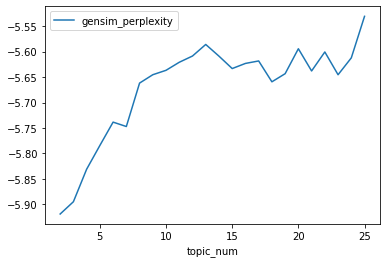

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-5.918797,371.964078
1,3,-5.894693,363.105476
2,4,-5.830861,340.651702
3,5,-5.784240,325.134709
4,6,-5.738400,310.567151
5,7,-5.747045,313.263609
6,8,-5.661780,287.660289
7,9,-5.645342,282.970199
8,10,-5.636675,280.528375
9,11,-5.620889,276.134886


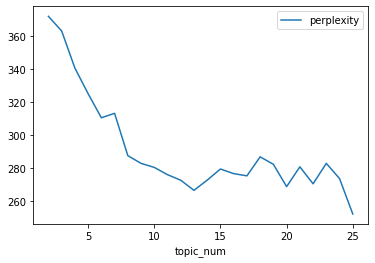

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_us_brief_paragraph_2010.csv", index=False)

## priority description sentence

In [11]:
# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(us_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in us_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_us_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

6

In [23]:
topics_us = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_us.append(c.index(max(c)))

In [24]:
topics_us

[6,
 14,
 22,
 20,
 3,
 23,
 11,
 14,
 23,
 14,
 2,
 18,
 2,
 6,
 10,
 20,
 12,
 11,
 23,
 1,
 5,
 1,
 24,
 22,
 19,
 8,
 8,
 16,
 9,
 4]

In [25]:
print(len(topics_us))
print(len(us_desc))

30
30


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2010 = db.rm_patent_us_2010
    db_rm_us_2010 = db.rm_patent_us_2010
    # db_rm_de_2010 = db.rm_patent_de_2010
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_us_desc = p_db_us.find({}, {"patentNumber":1, "brief": 1})
data_us_desc = db_rm_us_2010.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_us_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_us

,id,patentNumber,company,brief
0,62009c0f7b73c16636b3109a,US20130223235A1,[BlackBerry Ltd],A UE comprising a processor configured to perf...
1,6200a1987b73c16636b310d8,US8458315B2,[SAP SE],Embodiments of the present invention include s...
2,6200b2f77b73c16636b31110,US10198333B2,[Intel Corp],An apparatus and method is described herein fo...
3,6200c24e7b73c16636b311ac,US9030941B2,[Nokia Solutions and Networks Oy],There is proposed a mechanism for power saving...
4,6200c3ae7b73c16636b311d2,US9198185B2,[Nokia Solutions and Networks Oy],There is proposed a mechanism by means of whic...
5,6200c56e7b73c16636b311fa,US8891436B2,[Qualcomm Inc],A method and apparatus for effectively facilit...
6,6200cbcf7b73c16636b31212,US20110195731A1,[Samsung Electronics Co Ltd],An apparatus of a Base Station (BS) and a meth...
7,6200cc3c7b73c16636b31220,US20120087337A1,[Intel Corp],A method for an uplink power control mechanism...
8,6200cc597b73c16636b31228,US8587819B2,[Fujifilm Business Innovation Corp],A page layout control device having a receivin...
9,6200ccdc7b73c16636b31234,US20120108916A1,[],This invention relates to fitness monitors and...


In [30]:
print(len(df_us))
print(len(us_desc))

30
30


In [31]:
df_us["topic"]=topics_us

In [32]:
df_us

,id,patentNumber,company,brief,topic
0,62009c0f7b73c16636b3109a,US20130223235A1,[BlackBerry Ltd],A UE comprising a processor configured to perf...,6
1,6200a1987b73c16636b310d8,US8458315B2,[SAP SE],Embodiments of the present invention include s...,14
2,6200b2f77b73c16636b31110,US10198333B2,[Intel Corp],An apparatus and method is described herein fo...,22
3,6200c24e7b73c16636b311ac,US9030941B2,[Nokia Solutions and Networks Oy],There is proposed a mechanism for power saving...,20
4,6200c3ae7b73c16636b311d2,US9198185B2,[Nokia Solutions and Networks Oy],There is proposed a mechanism by means of whic...,3
5,6200c56e7b73c16636b311fa,US8891436B2,[Qualcomm Inc],A method and apparatus for effectively facilit...,23
6,6200cbcf7b73c16636b31212,US20110195731A1,[Samsung Electronics Co Ltd],An apparatus of a Base Station (BS) and a meth...,11
7,6200cc3c7b73c16636b31220,US20120087337A1,[Intel Corp],A method for an uplink power control mechanism...,14
8,6200cc597b73c16636b31228,US8587819B2,[Fujifilm Business Innovation Corp],A page layout control device having a receivin...,23
9,6200ccdc7b73c16636b31234,US20120108916A1,[],This invention relates to fitness monitors and...,14


In [33]:
df_us2 = df_us.explode('company')
df_us2

,id,patentNumber,company,brief,topic
0,62009c0f7b73c16636b3109a,US20130223235A1,BlackBerry Ltd,A UE comprising a processor configured to perf...,6
1,6200a1987b73c16636b310d8,US8458315B2,SAP SE,Embodiments of the present invention include s...,14
2,6200b2f77b73c16636b31110,US10198333B2,Intel Corp,An apparatus and method is described herein fo...,22
3,6200c24e7b73c16636b311ac,US9030941B2,Nokia Solutions and Networks Oy,There is proposed a mechanism for power saving...,20
4,6200c3ae7b73c16636b311d2,US9198185B2,Nokia Solutions and Networks Oy,There is proposed a mechanism by means of whic...,3
5,6200c56e7b73c16636b311fa,US8891436B2,Qualcomm Inc,A method and apparatus for effectively facilit...,23
6,6200cbcf7b73c16636b31212,US20110195731A1,Samsung Electronics Co Ltd,An apparatus of a Base Station (BS) and a meth...,11
7,6200cc3c7b73c16636b31220,US20120087337A1,Intel Corp,A method for an uplink power control mechanism...,14
8,6200cc597b73c16636b31228,US8587819B2,Fujifilm Business Innovation Corp,A page layout control device having a receivin...,23
9,6200ccdc7b73c16636b31234,US20120108916A1,NaN,This invention relates to fitness monitors and...,14


In [34]:
# 排名前16的公司
c_ls = list(df_us2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Xerox Corp',
 'Fujifilm Business Innovation Corp',
 'Nokia Solutions and Networks Oy',
 'Intel Corp',
 'Samsung Electronics Co Ltd',
 'Qualcomm Inc',
 'SAP SE',
 'United States, AS REPRENSENTED BY SECRETARY OF AIR FORCE',
 'US Air Force',
 'T Mobile USA Inc',
 'Alcatel Lucent SAS',
 'BlackBerry Ltd',
 'Hitachi High Tech Corp',
 'Calabazas Creek Res Center Inc',
 'CALABAZAS CREEK RESEARCH Inc',
 'Boeing Co']

### 轉成company-topic 的總數表格

In [35]:
df_us_count = df_us2.groupby(["company","topic"],as_index=False).size()
df_us_count

,company,topic,size
0,Alcatel Lucent SAS,18,1
1,BlackBerry Ltd,6,1
2,Boeing Co,20,1
3,CALABAZAS CREEK RESEARCH Inc,19,1
4,Calabazas Creek Res Center Inc,19,1
5,Fujifilm Business Innovation Corp,8,2
6,Fujifilm Business Innovation Corp,23,1
7,Hitachi High Tech Corp,1,1
8,Intel Corp,14,1
9,Intel Corp,22,1


In [36]:
# 轉成company-topic 的總數表格
table_us = df_us_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_us = table_us.droplevel(level=0, axis=1)
table_us = table_us.rename(columns={'':'company'})

In [37]:
table_us

topic,company,1,2,3,4,5,6,8,9,10,11,12,14,16,18,19,20,22,23,24
0,Alcatel Lucent SAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,BlackBerry Ltd,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Boeing Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,CALABAZAS CREEK RESEARCH Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Calabazas Creek Res Center Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,Fujifilm Business Innovation Corp,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,Hitachi High Tech Corp,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Intel Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,Nokia Solutions and Networks Oy,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,Qualcomm Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
final_table_us = table_us[table_us.company.isin(c_ls)]
final_table_us

topic,company,1,2,3,4,5,6,8,9,10,11,12,14,16,18,19,20,22,23,24
0,Alcatel Lucent SAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,BlackBerry Ltd,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Boeing Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,CALABAZAS CREEK RESEARCH Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Calabazas Creek Res Center Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,Fujifilm Business Innovation Corp,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,Hitachi High Tech Corp,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Intel Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,Nokia Solutions and Networks Oy,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,Qualcomm Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [39]:
final_table_us.shape

(16, 20)

In [40]:
table_us.to_csv('company_lda_brief_us_2010.csv',index=0)